In [1]:
import pandas as pd
import geopandas as gpd
import folium
import seaborn as sns

## Getting Started

In [2]:
m = folium.Map(
    location=[49.2827, -123.1207],
    tiles='Stamen Toner',
    zoom_start=11
)

m

In [3]:
zoning_geofile = f'data/zoning-districts-and-labels.geojson'

folium.GeoJson(
    zoning_geofile,
    name='geojson'
).add_to(m)

m.save('van_map.html')

In [4]:
zoning_geofile = f'data/zoning-districts-and-labels.geojson'
zoning_gdf = gpd.read_file(zoning_geofile)

In [5]:
# reproject to MTM, calculate area
zoning_gdf = zoning_gdf.to_crs({'init': 'epsg:26910'})
zoning_gdf.crs
zoning_gdf['area'] = zoning_gdf.area / 10000  # in hectares

# restore projection
zoning_gdf = zoning_gdf.to_crs({'init': 'epsg:4326'})
zoning_gdf.crs

/opt/conda/lib/python3.7/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/opt/conda/lib/python3.7/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


{'init': 'epsg:4326'}

In [6]:
zoning_gdf.head(5)

,category,zone_name,geometry,area
0,Light Industrial,I-2,"POLYGON ((-123.08908 49.27590, -123.08937 49.2...",150.585595
1,Two-Family Dwelling,RT-2,"POLYGON ((-123.06608 49.25460, -123.06633 49.2...",0.068840
2,Commercial,C-1,"POLYGON ((-123.02378 49.24451, -123.02377 49.2...",0.497827
3,Comprehensive Development,CD-1 (624),"POLYGON ((-123.02373 49.25063, -123.02458 49.2...",0.214817
4,Comprehensive Development,CD-1 (201),"POLYGON ((-123.03378 49.23848, -123.03287 49.2...",0.464762


## Chloropleth

* https://python-visualization.github.io/folium/quickstart.html#Choropleth-maps

In [7]:
m = folium.Map(
    location=[49.2827, -123.1207],
    tiles='Stamen Toner',
    zoom_start=11
)

folium.Choropleth(
    geo_data=zoning_geofile,
    name='choropleth',
    data=pd.DataFrame(zoning_gdf[['zone_name', 'area']]),
    # data=zoning_gdf[['zone_name', 'area']], # could be separate
    columns=['zone_name', 'area'],
    # key_on='feature.id',
    key_on='properties.zone_name',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='area'
).add_to(m)

folium.LayerControl().add_to(m)

m.save('van_map_zoning-area.html')

## Polygons with color by category

* https://stackoverflow.com/questions/35516318/plot-colored-polygons-with-geodataframe-in-folium

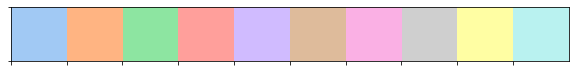

In [8]:
sns.palplot(sns.color_palette("pastel", 10))

In [9]:
df_cat = pd.DataFrame(zoning_gdf['category'].unique())
df_cat.rename(columns={0: 'category'}, inplace=True)

# df_col = pd.DataFrame(sns.color_palette("hls", len(df_cat)).as_hex())
df_col = pd.DataFrame(sns.color_palette("pastel", len(df_cat)).as_hex())
df_col.rename(columns={0: 'color'}, inplace=True)

df_catcol = pd.concat([df_cat, df_col], axis=1)
df_catcol

,category,color
0,Light Industrial,#a1c9f4
1,Two-Family Dwelling,#ffb482
2,Commercial,#8de5a1
3,Comprehensive Development,#ff9f9b
4,Multi-Family Dwelling,#d0bbff
5,One-Family Dwelling,#debb9b
6,Industrial,#fab0e4
7,Historical Area,#cfcfcf
8,Limited Agriculture,#fffea3
9,Other,#b9f2f0


In [10]:
# build a color column
zoning_gdf = zoning_gdf.merge(df_catcol, on='category')

In [11]:
zoning_gdf.head(5)

,category,zone_name,geometry,area,color
0,Light Industrial,I-2,"POLYGON ((-123.08908 49.27590, -123.08937 49.2...",150.585595,#a1c9f4
1,Light Industrial,I-2,"POLYGON ((-123.07682 49.26423, -123.07681 49.2...",0.499102,#a1c9f4
2,Light Industrial,I-1A,"POLYGON ((-123.10282 49.26645, -123.10161 49.2...",2.705232,#a1c9f4
3,Light Industrial,I-4,"POLYGON ((-123.09949 49.28409, -123.09886 49.2...",0.233317,#a1c9f4
4,Light Industrial,I-2,"POLYGON ((-123.08082 49.28004, -123.08082 49.2...",0.038229,#a1c9f4


In [12]:
m = folium.Map(
    location=[49.2827, -123.1207],
    tiles='Stamen Toner',
    zoom_start=11
)

folium.GeoJson(
    zoning_gdf,
    style_function=lambda feature: {
        'fillColor': feature['properties']['color'],
        'color': feature['properties']['color'],
        'weight': 1,
        'fillOpacity': 0.5,
    }
).add_to(m)

folium.LayerControl().add_to(m)

m.save('van_map_zoning-category.html')

/opt/conda/lib/python3.7/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


## Polygon with Category and pop ups

* https://stackoverflow.com/questions/54595931/show-different-pop-ups-for-different-polygons-in-a-geojson-folium-python-ma
* https://github.com/python-visualization/folium/issues/904

In [13]:
# prep json
import json
zoning_geojson = zoning_gdf.to_json()
zoning_geojson = json.loads(zoning_geojson)

In [14]:
# map settings
list_tooltip_vars = ['zone_name', 'category']
# http://maps.stamen.com/toner-lite/#12/37.7706/-122.3782
map_tiles = 'http://tile.stamen.com/toner-lite/{z}/{x}/{y}.png'

In [15]:
m = folium.Map(
    location=[49.2827, -123.1207],
    tiles=map_tiles,
    attr="toner-bcg",
    zoom_start=11
)

folium.GeoJson(
    zoning_gdf,
    style_function=lambda feature: {
        'fillColor': feature['properties']['color'],
        'color': feature['properties']['color'],
        'weight': 1,
        'fillOpacity': 0.5,
    },
    name='zoning layer',
    control=False
).add_to(m)

data_geojson_dict = zoning_geojson

layer_geom = folium.FeatureGroup(name='pop-up layer', control=False)

for i in range(len(data_geojson_dict["features"])):
    temp_geojson = {"features": [
        data_geojson_dict["features"][i]], "type": "FeatureCollection"}
    temp_geojson_layer = folium.GeoJson(temp_geojson,
                                        highlight_function=lambda x: {
                                            'weight': 3, 'color': 'grey'},
                                        control=False,
                                        style_function=lambda feature: {
                                            # temp_geojson["features"][0]['properties']['color'],
                                            'color': 'black',
                                            'weight': 0,
                                            'fillOpacity': 0,
                                        },
                                        # option 1: tooltip on mouse over
                                        tooltip=folium.features.GeoJsonTooltip(fields=list_tooltip_vars,
                                                                               aliases=[
                                                                                   x.capitalize()+":" for x in list_tooltip_vars],
                                                                               labels=True,
                                                                               sticky=False))
    # option 2: pop up on mouse click
    # folium.Popup(temp_geojson["features"][0]["properties"]["category"]).add_to(temp_geojson_layer)
    temp_geojson_layer.add_to(layer_geom)

layer_geom.add_to(m)
folium.LayerControl(autoZIndex=False, collapsed=True).add_to(m)

m.save('van_map_zoning-category-popup.html')

## Examples

In [ ]:
import pandas as pd


url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data'
state_geo = f'{url}/us-states.json'
state_unemployment = f'{url}/US_Unemployment_Oct2012.csv'
state_data = pd.read_csv(state_unemployment)

m = folium.Map(location=[48, -102], zoom_start=3)

folium.Choropleth(
    geo_data=state_geo,
    name='choropleth',
    data=state_data,
    columns=['State', 'Unemployment'],
    key_on='feature.id',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Unemployment Rate (%)'
).add_to(m)

folium.LayerControl().add_to(m)

m